# Wstęp

Na poprzednich zajęciach nauczyłeś(aś) się jak skonstruować od zera podstawową komórkę sieci neuronowej - Perceptron. Na tych zajęciach przejdziemy już do wykorzystywania bardziej zaawansowanych funkcji PyTorcha, które przydają się na codzień do konstruowania sieci neuronowych.

## Cel ćwiczenia

Celem ćwiczenia jest zapoznanie z podstawowymi funkcjami biblioteki PyTorch do tworzenia i uczenia sieci neuronowych a w szczególności z:
*   Automatycznym liczeniem gradientów i grafem obliczeniowym (autograd)
*   Algorytmami off-line, on-line a także pojęciem mini-batch
*   Algorytmami optymalizacji sieci neuronowych
*   Liczeniem wartości fuknkcji straty
*   Przekształceniami nieliniowymi
*   Modułem `torch.nn`

## Warunki zaliczenia

W celu zaliczenia ćwiczeń należy uzupełnić wszystkie brakujące elementu kodu, wykonać wszystkie polecenia i wyuczyć model.


In [1]:
import math
import warnings
from typing import Tuple

import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

assert torch.cuda.is_available(), "Uruchom środowisko wykonawcze na GPU"

# Autograd - automatyczne liczenie gradientów

Na poprzednich laboratoriach implementowałeś(aś) funkcję wstecznej propagacji. W tym celu liczyłaś(eś) pochodne (gradienty). Przyjrzyjmy się najpierw funkcji
$$f(x, y) = 3x^2 + y^3$$
Możemy tę funkcję różniczkować po dwóch zmiennych: $x$ i $y$:
$$\frac{\partial f}{\partial x} = 6x$$

$$\frac{\partial f}{\partial y} = 3y^2$$

Jeżeli funkcję $f(x,y)$ złożymy z funkcją $g(x) = x^2$ tworząc funkcję $h(x, y) = f(g(x), y)$ to z **reguły łańcuchowej** pochodna takiej funkcji wyniesie:

$$\frac{\partial h}{\partial x} = \frac{\partial f}{\partial g} \frac{\partial g}{\partial x} = (6 (x^2)) (2 x) = 12 x^3$$

Tego typu obliczenia przy wielu warstwach sieci (a więc przy wielu złożeniach funkcji liniowych i nieliniowych) stają się mocno skomplikowane. Na szczęście PyToch dostarcza `torch.autograd` - silnik do zaumatyzowanego liczenia gradientów. Jak on działa? Najpierw zdefiniujmy wektory $\mathbf x$ i $\mathbf y$.

In [2]:
x = torch.tensor([0., 1., 5.], requires_grad=True)
y = torch.tensor([8., 2., 4.], requires_grad=True)

Zauważ, że tworząc tensor przekazaliśmy parametr `requires_grad=True`. Sprawia on, że wszystkie operacje dokonane na tym tensorze są śledzone i tensor wynikowy będzie "pamiętał" przy użyciu jakiej operacji powstał. Policzmy naszą funkcję $f( \mathbf x, \mathbf y)$ dla tych tensorów.

In [3]:
z = 3*x**2 + y**3
z

tensor([512.,  11., 139.], grad_fn=<AddBackward0>)

Jak widać uzyskany tensor ma także zapisany parametr `grad_fn=<AddBackward0>`, czyli że powstał z dodania dwóch tensorów - dodawanie jest ostatnią operacją, która zostałą wykonana, żeby otrzymać ten tensor. Dokonajmy propagacji wstecznej w celu policzenia gradientów.


In [4]:
grad_tensors = torch.tensor([1., 1., 1.])
z.backward(grad_tensors)
print(x.grad == 6*x)
print(y.grad == 3*y**2)

tensor([True, True, True])
tensor([True, True, True])


Na razie nie przejmuj się tym za co odpowiada `grad_tensors`. Policzmy wartość funkcji $h$.



In [5]:
a = 3*(x**2)**2 + y**3
a.backward(grad_tensors)
print(x.grad)
print(12*(x**3))
print(x.grad == 12*(x**3))

tensor([   0.,   18., 1530.])
tensor([   0.,   12., 1500.], grad_fn=<MulBackward0>)
tensor([ True, False, False])


Nie zgadzają nam się wartości. Wynika to z kolejnej właśności pytorchowego autograda - gradienty w tensorach są **akumulowane**. Jak wykonasz powyższą komórkę wielekrotnie to zobaczysz że wartości `x.grad` rosną dokładnie o $12x_i^3$ po każdym wykonaniu. Akumulacja gradientów jest przydatna w niektórych architekturach sieci neuronowych. Dlatego też trzeba *explicite* wyzerować gradienty.

In [6]:
x.grad.data.zero_()
a = 3*(x**2)**2 + y**3
a.backward(grad_tensors)
print(x.grad)
print(12*(x**3))
assert (x.grad == 12*(x**3)).all()

tensor([   0.,   12., 1500.])
tensor([   0.,   12., 1500.], grad_fn=<MulBackward0>)


Ok, powróćmy teraz do `grad_tensors` - co to jest? Otóż autograd jest silnikiem, który służy do wyliczania **macierzy Jacobiego**, tj. pochodnych pierwszego rzędu funkcji, których składowymi są funkcje rzeczywiste.

$$f = (f_1, f_2, \ldots, f_m)$$
$$\mathbf x = (x_1, x_2, \ldots, x_n)$$

$$\mathbf J = \begin{bmatrix}
 \dfrac{\partial f_1}{\partial x_1} & \cdots & \dfrac{\partial f_1}{\partial x_n} \\
 \vdots & \ddots & \vdots \\
 \dfrac{\partial f_m}{\partial x_1} & \cdots & \dfrac{\partial f_m}{\partial x_n}
\end{bmatrix}$$

Konkretnie patrząc na przykład z tensorem $a$ macierz Jacobiego wygląda tak:
$$\mathbf J_a = \begin{bmatrix}
 \dfrac{\partial a_1}{\partial x_1} & \dfrac{\partial a_1}{\partial x_2} & \dfrac{\partial a_1}{\partial x_3} \\
  \dfrac{\partial a_2}{\partial x_1} & \dfrac{\partial a_2}{\partial x_2} & \dfrac{\partial a_2}{\partial x_3} \\
   \dfrac{\partial a_3}{\partial x_1} & \dfrac{\partial a_3}{\partial x_2} & \dfrac{\partial a_3}{\partial x_3} \\
\end{bmatrix}$$

Następnie `grad_tensors` ($\mathbf z$) mnożymy przez transpozycję tej macierzy (ang. *Jacobian-vector product*).

$$\mathbf z \mathbf{J}_a^T = \begin{bmatrix} 1 & 1 & 1 \end{bmatrix}

\begin{bmatrix}
 \dfrac{\partial a_1}{\partial x_1} & \dfrac{\partial a_2}{\partial x_1} & \dfrac{\partial a_3}{\partial x_1} \\
  \dfrac{\partial a_1}{\partial x_2} & \dfrac{\partial a_2}{\partial x_2} & \dfrac{\partial a_3}{\partial x_2} \\
   \dfrac{\partial a_1}{\partial x_3} & \dfrac{\partial a_2}{\partial x_3} & \dfrac{\partial a_3}{\partial x_3} \\
\end{bmatrix}

= \begin{bmatrix} 1\dfrac{\partial a_1}{\partial x_1} + 1\dfrac{\partial a_1}{\partial x_2} + 1\dfrac{\partial a_1}{\partial x_3} & 1\dfrac{\partial a_2}{\partial x_1} + 1\dfrac{\partial a_2}{\partial x_2} + 1\dfrac{\partial a_2}{\partial x_3} & 1\dfrac{\partial a_3}{\partial x_1} + 1\dfrac{\partial a_3}{\partial x_2} + 1\dfrac{\partial a_3}{\partial x_3} \end{bmatrix}

= \begin{bmatrix} 12(0)^3 + 0 + 0 & 0 + 12(1)^3 + 0 & 0 + 0 + 12(5)^3 \end{bmatrix} =  \begin{bmatrix} 0 & 12 & 1500 \end{bmatrix}$$

Uzyskujemy te same gradienty co policzyliśmy dla wektora $\mathbf x$. Zamiast przekazywać wektor jedynek do `backward()`, można najpierw policzyć sumę wektora $\mathbf a$ a potem wykonać propagację wsteczną.

In [7]:
x.grad.data.zero_()
a = 3*(x**2)**2 + y**3
a.sum().backward()
print(x.grad)
print(12*(x**3))
assert (x.grad == 12*(x**3)).all()

tensor([   0.,   12., 1500.])
tensor([   0.,   12., 1500.], grad_fn=<MulBackward0>)


Wtedy pamiętając o tym, że pochodna sumy to suma pochodnych ($(f(x) + g(x))' = f'(x) + g'(x)$):

$$\begin{bmatrix}
 \dfrac{\partial a}{\partial x_1} & \dfrac{\partial a}{\partial x_2} & \dfrac{\partial a}{\partial x_3}
\end{bmatrix} = \begin{bmatrix} \dfrac{\partial (a_1 + a_2 + a_3)}{\partial x_1} & \dfrac{\partial (a_1 + a_2 + a_3)}{\partial x_2} & \dfrac{\partial (a_1 + a_2 + a_3)}{\partial x_3} \end{bmatrix} = \begin{bmatrix} \dfrac{\partial a_1}{\partial x_1} + \dfrac{\partial a_2}{\partial x_1} + \dfrac{\partial a_3}{\partial x_1} & \dfrac{\partial a_1}{\partial x_2} + \dfrac{\partial a_2}{\partial x_2} + \dfrac{\partial a_3}{\partial x_2} & \dfrac{\partial a_1}{\partial x_3} + \dfrac{\partial a_2}{\partial x_3} + \dfrac{\partial a_3}{\partial x_3} \end{bmatrix} = \begin{bmatrix} \dfrac{\partial a_1}{\partial x_1} & \dfrac{\partial a_2}{\partial x_2} & \dfrac{\partial a_3}{\partial x_3} \end{bmatrix} =  \begin{bmatrix} 0 & 12 & 1500 \end{bmatrix} $$

Zatem po co w ogóle ten wektor? Otóż służy on do przekazywania wektora gradientu funkcji straty ($\dfrac{\partial \mathbf{loss}}{\partial \mathbf w}$). Dzięki temu możemy mieć wpływ na to jaką poprawkę trzeba wykonać na danym wektorze (np. z parametrami modelu) względem tego jak bardzo mocno model pomylił się na danych uczących.

In [8]:
x.grad.data.zero_()
a = 3*(x**2)**2 + y**3
a.backward(torch.tensor([0., 0.3, -0.4]))
print(x.grad)
print(12*(x**3))

tensor([   0.0000,    3.6000, -600.0001])
tensor([   0.,   12., 1500.], grad_fn=<MulBackward0>)


## Graf obliczeniowy

To wszystko jest możliwe dzięki temu, że autograd tworzy **acykliczny skierowany graf obilczeniowy**. Gdzie go przechowuje? Spójrzmy jeszcze raz na nasz wektor $\mathbf a$.

In [9]:
print(a)
print(a.grad_fn.next_functions)

tensor([ 512.,   11., 1939.], grad_fn=<AddBackward0>)
((<MulBackward0 object at 0x000001FE92E47A90>, 0), (<PowBackward0 object at 0x000001FE916B3520>, 0))


Obiekt a ma pole `grad_fn` a ono ma pole `next_functions`. Widzimy, że $\mathbf a$ powstało z przemnożenia dwóch tensorów, gdzie pierwszy tensor był wynikiem mnożenia a drugi - potęgowania. A więc na razie wiemy, że `a = (_*_) + (_**_)`. I kolejno przechodząc po tym grafie możemy dalej odkrywać jego strukturę i jaka droga skonstruowania $\mathbf a$ się za nim kryje.

In [10]:
print(a.grad_fn.next_functions[0][0].next_functions) # a = ((_**_))*_) + (_**_)
print(a.grad_fn.next_functions[0][0].next_functions[0][0].next_functions) # a = (((_**_))**_))*_) + (_**_)
print(a.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions) # a = (((x**_))**_))*_) + (_**_)
print()
print(a.grad_fn.next_functions[1][0].next_functions) # a = (((x**_))**_))*_) + (y**_)

((<PowBackward0 object at 0x000001FE8A3ACCA0>, 0), (None, 0))
((<PowBackward0 object at 0x000001FE91938190>, 0),)
((<AccumulateGrad object at 0x000001FE8A3ACCA0>, 0),)

((<AccumulateGrad object at 0x000001FE91938190>, 0),)


Po chwilii analizy można dostrzec że ta strutura odpowiada obliczeniu tensora $a$ ze wzoru $3(\mathbf x^2)^2 + \mathbf y^3$.

Jeszcze warto wspomnieć o tym, że PyTorch śledzi to dla których tensorów trzeba tworzyć ten graf a dla których nie. Dlatego też jeżeli w operacjach użyjemy tensora, który "wymaga gradientu" (`requires_grad=True`) to uzyskamy tensor "wymagający gradientu":

In [11]:
x = torch.tensor([1., 2., 3.])
y = torch.tensor([6., 7., 8.])
z = torch.tensor([9., 7., 8.], requires_grad=True)
print((2*x + 3**y).requires_grad)
print((2*x + 3**y + z).requires_grad)

False
True


# Refactoring kodu z laboratorium 2

W tej części laboratorium dokonasz refaktoringu kodu z laboratorium drugiego z wykorzystaniem gotowych rozwiązań w bibliotece `torch` a w szczególności w `torch.nn`. Najpierw zacznijmy od załadowania zbioru danych i podzielenia go na zbiór uczący i testowy.

In [12]:
X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)

X_train = torch.tensor(X_train).float().cuda()
X_test = torch.tensor(X_test).float().cuda()
y_train = torch.tensor(y_train).cuda()
y_test = torch.tensor(y_test).cuda()

y_test

tensor([0, 2, 0, 1, 2, 1, 1, 2, 2, 0, 2, 0, 2, 2, 1, 1, 2, 1, 2, 1, 0, 0, 2, 0,
        1, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 2, 1, 2, 0, 0, 2, 2, 1, 0,
        0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 1], device='cuda:0',
       dtype=torch.int32)

## `nn.Module` oraz `CrossEntropyLoss`

Na poprzednich laboratoriach w tym miejscu implementowaliśmy funkcję sigmoid, inicjalizację parametrów oraz propagację w przód i wsteczną. Tym razem nie będzie trzeba tego robić, jednakże zdefiniujesz architekturę sieci przy użyciu modułu `torch.nn`.

***Zaimplementuj*** klasę Perceptron - klasę dziedziczącą po `nn.Module` z jedną warstwą transformacji liniowej (Perceptrona, [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)). Na razie ***pomiń*** transformację nieliniową (np. sigmoid).



In [13]:
class Perceptron(nn.Module):
    def __init__(self, int_dim: int = 4, out_dim: int = 3):
        super().__init__()
        self.int_dim = int_dim
        self.out_dim = out_dim
        self.net = nn.Linear(self.int_dim, self.out_dim) # Użyj nn.Linear

    def forward(self, x: torch.Tensor):
        return self.net(x)


Wspominmy tylko, że można nadal używać `torch.nn` i nie wykorzystywać gotowych warstw sieci tylko samemu implementować operacje na tensorach:

```
class Perceptron(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.weights = nn.Parameter(
          torch.randn(in_dim, out_dim) / math.sqrt(in_dim)
        )
        self.bias = nn.Parameter(torch.zeros(out_dim))

    def forward(self, xb: torch.Tensor):
        return xb @ self.weights + self.bias
```
***Przetestuj*** poprawność swojej implementacji.

In [14]:
model = Perceptron().cuda()
y_pred_0 = model(X_train[0])
print(y_pred_0)

assert isinstance(y_pred_0, torch.cuda.FloatTensor)
assert len(y_pred_0) == 3

tensor([-0.3804,  1.3838, -4.0090], device='cuda:0', grad_fn=<ViewBackward0>)


Wykorzystanie `nn.Linear` nie tylko odciążyło nas z implementacji operacji na tensorasch, ale także z inicjalizacji paprametrów modelu - inicjalizacja parametrów jest domyślnie implementowana przez daną wartstwę. Jeżeli uruchomisz powyższy kod wielokrotnie to zauważysz, że za każdym razem otrzymujesz inny tensor wyjściowy. Wynika to z tego, że początkowe parametry modelu są domyślnie **losowane**. Oznacza to, że proces uczenia będzie **niedeterministryczny** - każde uruchomienie da inny wynik parametrów, które model się nauczy.

Pozostało jeszcze dodanie nieliniowej transformacji do sieci, ale nie będziemy tego robić. Dodatkowo zamiast tworzyć osobny klasifikator na klasę, zastosujemy jeden klasyfikator. W tym celu zmieniemy funkcję kosztu. Do klasyfikacji wieloklasowej wykorzystamy funkcję **straty krzyżowej entropii**.

$\text{loss} = -\frac{1}{N}\sum_{i}^{N}\log(\text{softmax}(x_{i}){y_{i}}) $, gdzie $N$ oznacza liczbę przypadków, $x_{i}$ wyjście z ostatniej warstwy $i$-tej instancji, $y_{i}$ klasę $i$-tej instancji.

**Softmax** jest przekstałceniem nielinowym powszechnie używanym jako ostatnia warstwa sieci neuronowej służącej do klasyfikacji. Jej mocną stroną jest to, że suma wszystkich elementów tensora będących na jej wyjściu wynosi $1$. Dzięki temu możemy wyjście sieci interpretować jako przypisanie pseudoprawdopodbieństwa dla klasyfikacji dla danej próbki.

Dla danego wektora $\mathbf x = (x_1, x_2, \ldots, x_i, \ldots, x_C)$ funkcja Softmax jest zdefiniowana jako:
$\text{Softmax}(x_{i}) = \frac{\exp(x_{i})}{\sum_{j}^{C} \exp(x_{j})}$, gdzie $C$ oznacza liczbę klas.

W tym zadaniu nie będziemy implementować tych funkcji samemu tylko wykorzystamy gotową implementację w bibliotece torch. Implementację znajdziemy w [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Przyjmuje ona "surowe" wartości, dlatego że oblicza również funkcję **LogSoftmax**. Alternatywnie możemy nałożyć funkcję aktywacji LogSoftmax z modułu [`torch.nn.LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html) i obliczyć negatywny logarytm funkcji wiarygodności (ang. *negative log likelihood*) [`torch.nn.NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss). `torch.nn.NLLLoss` nie wykonuje operacji logarytmowania tylko oczekuje zlogarytmowanego wejścia.

**LogSoftmax** wykorzystany jest tutaj nieprzypadkowo. Funkcja softmax w oryginalnej postaci nie jest odparna na wystąpienie niestabilności numerycznych. W przypadku liczenia entropii krzyżowej możemy wykorzystać skalę logarytmiczną do przeprowadzenia operacji. Dzięki przenesieniu obliczania logarytmu do funkcji Softmax możemy zastąpić dzielenie na różnicę logarytmów. czyli zamiast powyższej definicji funkcja LogSoftmax przyjmuję następującą postać:

$\text{LogSoftmax}(x_{i}) = x_{i} - log \bigg({\sum_{j}^{C} \exp(x_{j})}\bigg)$

Dodatkowo stosowany jest także trik polegający na zastąpieniu operacji $log \bigg({\sum_{j}^{C} \exp(x_{j})}\bigg)$ operacją **LogSumExp**, zdefiniowaną jako

$\text{LogSumExp}(\mathbf x) = \max(\mathbf x) + log \bigg({\sum_{j}^{C} \exp(x_{j} - \max(\mathbf x))}\bigg)$.

Pozwala to pozbyć się dużych wartości $x_{j}$ podczas obliczania $\exp$.



## Algorytmy online i offline (`DataLoader`)

Na poprzednich zajęciach zaimplementowałaś(eś) **algorytm offline** (alternatywnie batchowy lub deterministyczny, ang. *offline*, *batch*, *deterministic*) tzn. taki, który przetwarza od razu wszystkie dane. Jednakże implementując sieci neuronowe tworzymy często algorytmy **online** (alternatywnie stochastyczne, ang. *online*, *stochastic*), które przetwarzają dane w "kawałkach" lub wręcz mogą dostawać je "na bieżąco" bez konieczności posiadania wszystkcih danych przed uruchomieniem algorytmu. Są różne powody, dla których tak się robi, ale najczęstrzy jest taki, że przy głębszych architektrurach i bardziej złożonych obiektach (np. obrazach) byłoby fizycznie nie możliwe pomieścić te wszystkie dane w pamięci RAM lub VRAM (RAM na GPU) wraz z parametrami modelu.

Liczbę próbek w algorytmach stochastycznych w sieciach neuronowych określa się jako **minibatch size** lub po prostu **batch size**. Przy czym określenie *batch size* nie odnosi się tutaj do algorytmów batchowych (operujących na całym zbiorze danych), tylko do algorytmów online/minibatch. Po prostu *batch size* jest określeniem krótszym (ale mniej poprawnym) niż *minibatch size*, stąd też powszechnie używa się tego pierwszego. Z tego też powodu czasami niektórzy używają określenia *batch* na *minibatch* - warto mieć to na uwadze przy komunikowaniu się z innymi osobami.

Do zaimplementowania minibatchy wykorzystamy [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). ***Zaimplementuj*** funkcję `to_dataloader`, która `X_train` i `y_train` oraz `X_test` i `y_test` umieści w dwóch osobnych instancjach klasy `DataLoader` z wielkością minibatacha równą `batch_size`

In [15]:
def to_dataloader(
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    batch_size: int = 32
) -> Tuple[DataLoader, DataLoader]:
    train_ds = TensorDataset(X_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    test_ds = TensorDataset(X_test, y_test)
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    return train_dl, test_dl

***Przetestuj*** implementację

In [16]:
train_loader, test_loader = to_dataloader(
    X_train=X_train,  y_train=y_train,
    X_test=X_test, y_test=y_test,
    batch_size=32
)

for sample in test_loader:
    print(sample)

[tensor([[5.1000, 3.8000, 1.9000, 0.4000],
        [7.4000, 2.8000, 6.1000, 1.9000],
        [4.6000, 3.2000, 1.4000, 0.2000],
        [6.4000, 2.9000, 4.3000, 1.3000],
        [7.3000, 2.9000, 6.3000, 1.8000],
        [7.0000, 3.2000, 4.7000, 1.4000],
        [5.1000, 2.5000, 3.0000, 1.1000],
        [7.2000, 3.2000, 6.0000, 1.8000],
        [6.7000, 2.5000, 5.8000, 1.8000],
        [5.0000, 3.4000, 1.5000, 0.2000],
        [6.1000, 3.0000, 4.9000, 1.8000],
        [5.1000, 3.5000, 1.4000, 0.2000],
        [6.9000, 3.2000, 5.7000, 2.3000],
        [6.2000, 3.4000, 5.4000, 2.3000],
        [6.0000, 3.4000, 4.5000, 1.6000],
        [6.1000, 3.0000, 4.6000, 1.4000],
        [6.8000, 3.0000, 5.5000, 2.1000],
        [6.8000, 2.8000, 4.8000, 1.4000],
        [5.7000, 2.5000, 5.0000, 2.0000],
        [6.2000, 2.2000, 4.5000, 1.5000],
        [5.7000, 4.4000, 1.5000, 0.4000],
        [5.0000, 3.5000, 1.6000, 0.6000],
        [6.7000, 3.3000, 5.7000, 2.5000],
        [4.4000, 2.9000, 1.4000, 

## Ewaluacja modelu - metryki

***Zaimplementuj*** funkcję `validate`, które dla danego modelu, funkcji straty i loadera zwróci średnią wartość funkcji straty oraz dokładność (ang. *accuracy*) dla danych z `dataloader`.

In [17]:
def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module,
    loss_fn: torch.nn.CrossEntropyLoss,
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch)
        y_batch = y_batch.type(torch.long)
        all += len(y_pred)
        loss += len(y_pred) * loss_fn(y_pred, y_batch)
        correct += count_correct(y_pred, y_batch)
    return loss / all, correct / all


***Przetestuj*** swoją implementację

In [18]:
loss_fn = torch.nn.CrossEntropyLoss()
val_train, acc_train = validate(model, loss_fn, test_loader)
print(val_train, acc_train)

tensor(2.6445, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3333, device='cuda:0')


## Uczenie

Przed uzupełnieniem poniżej implementacji została nam jeszcze jedna istotna kwestia do poruszenia. Otóż dot tej pory aktualizację parametrów dokonywaliśmy wg prostej formuły - mnożyliśmy gradienty przez współczynnik uczenia (ang. *learning rate*) i odejmowalismy od parametrów. Jednakże do uczenia sieci neuronowych sotsujemy często optymalizatory (ang. *optimiser*), które mogą implementować różne podejścia do uakualiniania parameterów modelu. Wykorzystamy tutaj algorytm **Adam** (ang. *adaptive moment estimation*), który dostosowuje współczynnik uczenia do poszczególnych parametrów i jest często optimizatorem pierwszego wyboru.

***Uzupełnij i przetestuj*** poniższą implementację uczenia modelu. Porównaj jej skuteczność z tą, którą zaimplementowałeś(aś) na laboratorium 2.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
PRINTIT=True
def fit(
    model: nn.Module, optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader,
    val_dl: DataLoader, epochs: int,
    print_metrics: str = True
):  
    train_loss_tab = []
    train_acc_tab = []
    val_loss_tab = []
    val_acc_tab = []
    for epoch in range(epochs):
        for X_batch, y_batch in train_dl:
            y_pred = model(X_batch) # Uzyskanie pseudoprawdopodobieństw dla próbek z minibatcha
            y_batch = y_batch.type(torch.long)
            loss = loss_fn(y_pred, y_batch) # Policzenie funkcji straty

            loss.backward() # Wsteczna propagacja z wyniku funkcji straty - policzenie gradientów i zapisanie ich w tensorach (parametrach)
            optimiser.step() # Aktualizacja parametrów modelu przez optymalizator na podstawie gradientów zapisanych w tensorach (parametrach) oraz lr
            optimiser.zero_grad() # Wyzerowanie gradientów w modelu, alternatywnie można wywołać percepron.zero_grad()

        if print_metrics:
            model.eval() # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropuot czy BatchNorm
            with torch.no_grad():  # Wstrzymujemy przeliczanie i śledzenie gradientów dla tensorów - w procesie ewaluacji modelu nie chcemy zmian w gradientach
                train_loss, train_acc = validate(model, loss_fn, train_dl)
                val_loss, val_acc = validate(model, loss_fn, val_dl)
                if PRINTIT:
                    print(
                        f"Epoch {epoch}: "
                        f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                        f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
                    )
                train_loss_tab.append(train_loss.item())
                train_acc_tab.append(train_acc.item())
                val_loss_tab.append(val_loss.item())
                val_acc_tab.append(val_acc.item())
    df_output = pd.DataFrame({'train_loss':train_loss_tab, 'train_acc':train_acc_tab, 'val_loss': val_loss_tab, 'val_acc':val_acc_tab})
    model.eval() # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropuot czy BatchNorm
    return df_output
train_dl, test_dl = to_dataloader(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    batch_size=32
)
perceptron = Perceptron().cuda()
optimiser = optim.Adam(perceptron.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
fit(
    model=perceptron, optimiser=optimiser, loss_fn=loss_fn,
    train_dl=train_dl, val_dl=test_dl, epochs=50
)

Epoch 0: train loss = 1.589 (acc: 0.333), validation loss = 1.584 (acc: 0.333)
Epoch 1: train loss = 1.558 (acc: 0.333), validation loss = 1.553 (acc: 0.333)
Epoch 2: train loss = 1.527 (acc: 0.333), validation loss = 1.523 (acc: 0.333)
Epoch 3: train loss = 1.497 (acc: 0.333), validation loss = 1.493 (acc: 0.333)
Epoch 4: train loss = 1.468 (acc: 0.344), validation loss = 1.465 (acc: 0.333)
Epoch 5: train loss = 1.438 (acc: 0.344), validation loss = 1.436 (acc: 0.333)
Epoch 6: train loss = 1.410 (acc: 0.356), validation loss = 1.409 (acc: 0.333)
Epoch 7: train loss = 1.383 (acc: 0.356), validation loss = 1.382 (acc: 0.350)
Epoch 8: train loss = 1.357 (acc: 0.356), validation loss = 1.357 (acc: 0.367)
Epoch 9: train loss = 1.332 (acc: 0.389), validation loss = 1.332 (acc: 0.367)
Epoch 10: train loss = 1.306 (acc: 0.389), validation loss = 1.307 (acc: 0.383)
Epoch 11: train loss = 1.282 (acc: 0.433), validation loss = 1.284 (acc: 0.400)
Epoch 12: train loss = 1.259 (acc: 0.444), validat

,train_loss,train_acc,val_loss,val_acc
0,1.589373,0.333333,1.583721,0.333333
1,1.557799,0.333333,1.552821,0.333333
2,1.527085,0.333333,1.522780,0.333333
3,1.496654,0.333333,1.493033,0.333333
4,1.467516,0.344444,1.464566,0.333333
5,1.438445,0.344444,1.436172,0.333333
6,1.410202,0.355556,1.408604,0.333333
7,1.383321,0.355556,1.382377,0.350000
8,1.357150,0.355556,1.356852,0.366667
9,1.331569,0.388889,1.331921,0.366667


***Uzupełnij*** funkcję `fit`, aby ta mogła logować metryki (*loss*, *accuracy*) per epokę. Po zebraniu historii uczenia ***przedstaw*** następujące wykresy:
- Wykres wartości funkcji kosztu w zależności od epoki uczenia dla zbioru uczącego i testowego
- Wykres wartości metryki *accuracy* w zależności od epoki uczenia dla zbioru uczącego i testowego

Metryki dla obu zbiorów przedstaw na jednym wykresie jako serie. ***Uzupełnij*** etykiety osi i tytuły wykresów.

In [21]:
PRINTIT = False
perceptron = Perceptron().cuda()
optimiser = optim.Adam(perceptron.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
df = fit(
    model=perceptron, optimiser=optimiser, loss_fn=loss_fn,
    train_dl=train_dl, val_dl=test_dl, epochs=500
)

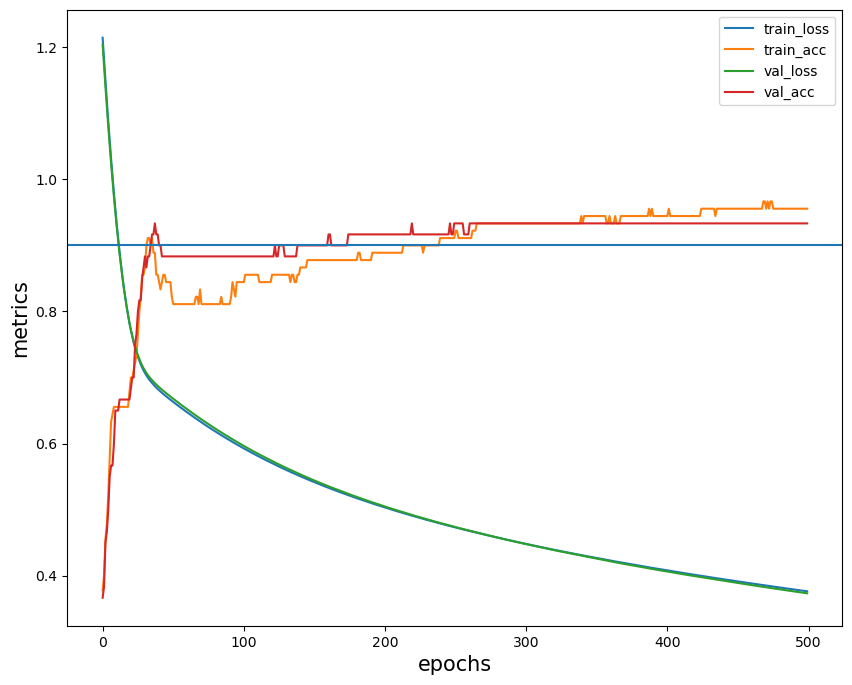

In [22]:
fig, ax  = plt.subplots(figsize = (10,8))
for col in df.columns:
    ax.plot(df.index, df[col], label = col)
ax.set_xlabel('epochs', fontsize = 15)
ax.set_ylabel('metrics', fontsize = 15)
ax.axhline(0.9)
ax.legend()

***Popraw*** model, tak aby otrzymać dokładność na zbiorze testowym wynoszącą co najmniej 90%. W tym celu dobierz odpowiedni współczynnik uczenia i liczbę epok.
Do porównania badanych hiperparametrów użyj zbioru walidacyjnego. Podziel zbiór testowy na dwie równe części, jeden który będzie służyć do walidacji hiperparametrów, a drugi, który będzie służył do ewaluacji znalezionej najlepszej pary hiperparametrów. W tym celu możesz wykorzystać funkcję `torch.utils.data.random_split` z ustawionym parametrem `generator=torch.Generator().manual_seed(1)`. Przedstaw równiez wykresy o których mowa punkcie powyżej tym razem z uwzględniem trzech zbiorów (uczącego, walidacyjnego i testowego)

In [23]:
import math
from torch import default_generator, randperm
from torch._utils import _accumulate
from torch.utils.data.dataset import Subset

def random_split(dataset, lengths,
                 generator=default_generator):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    If a list of fractions that sum up to 1 is given,
    the lengths will be computed automatically as
    floor(frac * len(dataset)) for each fraction provided.

    After computing the lengths, if there are any remainders, 1 count will be
    distributed in round-robin fashion to the lengths
    until there are no remainders left.

    Optionally fix the generator for reproducible results, e.g.:

    >>> random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
    >>> random_split(range(30), [0.3, 0.3, 0.4], generator=torch.Generator(
    ...   ).manual_seed(42))

    Args:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths or fractions of splits to be produced
        generator (Generator): Generator used for the random permutation.
    """
    if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
        subset_lengths: List[int] = []
        for i, frac in enumerate(lengths):
            if frac < 0 or frac > 1:
                raise ValueError(f"Fraction at index {i} is not between 0 and 1")
            n_items_in_split = int(
                math.floor(len(dataset) * frac)  # type: ignore[arg-type]
            )
            subset_lengths.append(n_items_in_split)
        remainder = len(dataset) - sum(subset_lengths)  # type: ignore[arg-type]
        # add 1 to all the lengths in round-robin fashion until the remainder is 0
        for i in range(remainder):
            idx_to_add_at = i % len(subset_lengths)
            subset_lengths[idx_to_add_at] += 1
        lengths = subset_lengths
        for i, length in enumerate(lengths):
            if length == 0:
                warnings.warn(f"Length of split at index {i} is 0. "
                              f"This might result in an empty dataset.")

    # Cannot verify that dataset is Sized
    if sum(lengths) != len(dataset):    # type: ignore[arg-type]
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()  # type: ignore[call-overload]
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

In [24]:
def to_dataloader(
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    batch_size: int = 32
) -> Tuple[DataLoader, DataLoader]:
    train_ds = TensorDataset(X_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    test_ds = TensorDataset(X_test, y_test)
    new_val_ds, new_test_ds = random_split(test_ds, [0.5, 0.5], generator=torch.Generator().manual_seed(1))
    val_dl = DataLoader(new_val_ds, batch_size = batch_size, shuffle=True)
    test_dl = DataLoader(new_test_ds, batch_size=batch_size, shuffle=True)

    return train_dl, val_dl, test_dl

In [25]:
def fit(
    model: nn.Module, optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader,
    val_dl: DataLoader, test_dl:DataLoader,epochs: int,
    print_metrics: str = True
):  
    train_loss_tab = []
    train_acc_tab = []
    val_loss_tab = []
    val_acc_tab = []
    test_loss_tab = []
    test_acc_tab = []
    for epoch in range(epochs):
        for X_batch, y_batch in train_dl:
            y_pred = model(X_batch) # Uzyskanie pseudoprawdopodobieństw dla próbek z minibatcha
            y_batch = y_batch.type(torch.long)
            loss = loss_fn(y_pred, y_batch) # Policzenie funkcji straty

            loss.backward() # Wsteczna propagacja z wyniku funkcji straty - policzenie gradientów i zapisanie ich w tensorach (parametrach)
            optimiser.step() # Aktualizacja parametrów modelu przez optymalizator na podstawie gradientów zapisanych w tensorach (parametrach) oraz lr
            optimiser.zero_grad() # Wyzerowanie gradientów w modelu, alternatywnie można wywołać percepron.zero_grad()

        if print_metrics:
            model.eval() # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropuot czy BatchNorm
            with torch.no_grad():  # Wstrzymujemy przeliczanie i śledzenie gradientów dla tensorów - w procesie ewaluacji modelu nie chcemy zmian w gradientach
                train_loss, train_acc = validate(model, loss_fn, train_dl)
                val_loss, val_acc = validate(model, loss_fn, val_dl)
                if PRINTIT:
                    print(
                        f"Epoch {epoch}: "
                        f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                        f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
                    )
                train_loss_tab.append(train_loss.item())
                train_acc_tab.append(train_acc.item())
                val_loss_tab.append(val_loss.item())
                val_acc_tab.append(val_acc.item())
        test_loss, test_acc = validate(model, loss_fn, test_dl)
        test_loss_tab.append(test_loss.item())
        test_acc_tab.append(test_acc.item())
    df_output = pd.DataFrame({'train_loss':train_loss_tab, 'train_acc':train_acc_tab, 'val_loss': val_loss_tab, 'val_acc':val_acc_tab, 'test_loss': test_loss_tab, 'test_acc':test_acc_tab})
    model.eval() # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropuot czy BatchNorm
    return df_output
train_dl, val_dl, test_dl = to_dataloader(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    batch_size=32
)
perceptron = Perceptron().cuda()
optimiser = optim.Adam(perceptron.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
df = fit(
    model=perceptron, optimiser=optimiser, loss_fn=loss_fn,
    train_dl=train_dl, val_dl=val_dl, test_dl=test_dl, epochs=100
)

In [36]:
for x,y in train_dl:
    print(y)

tensor([2, 2, 0, 1, 2, 0, 0, 1, 1, 2, 1, 2, 1, 0, 0, 2, 2, 0, 2, 0, 0, 1, 2, 2,
        1, 2, 0, 1, 2, 1, 2, 2], device='cuda:0', dtype=torch.int32)
tensor([0, 1, 1, 2, 2, 1, 2, 2, 0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 2, 1, 0, 0, 0, 0,
        2, 2, 0, 1, 1, 0, 1, 1], device='cuda:0', dtype=torch.int32)
tensor([1, 0, 2, 2, 2, 0, 0, 0, 2, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 2, 2, 1, 0,
        1, 1], device='cuda:0', dtype=torch.int32)


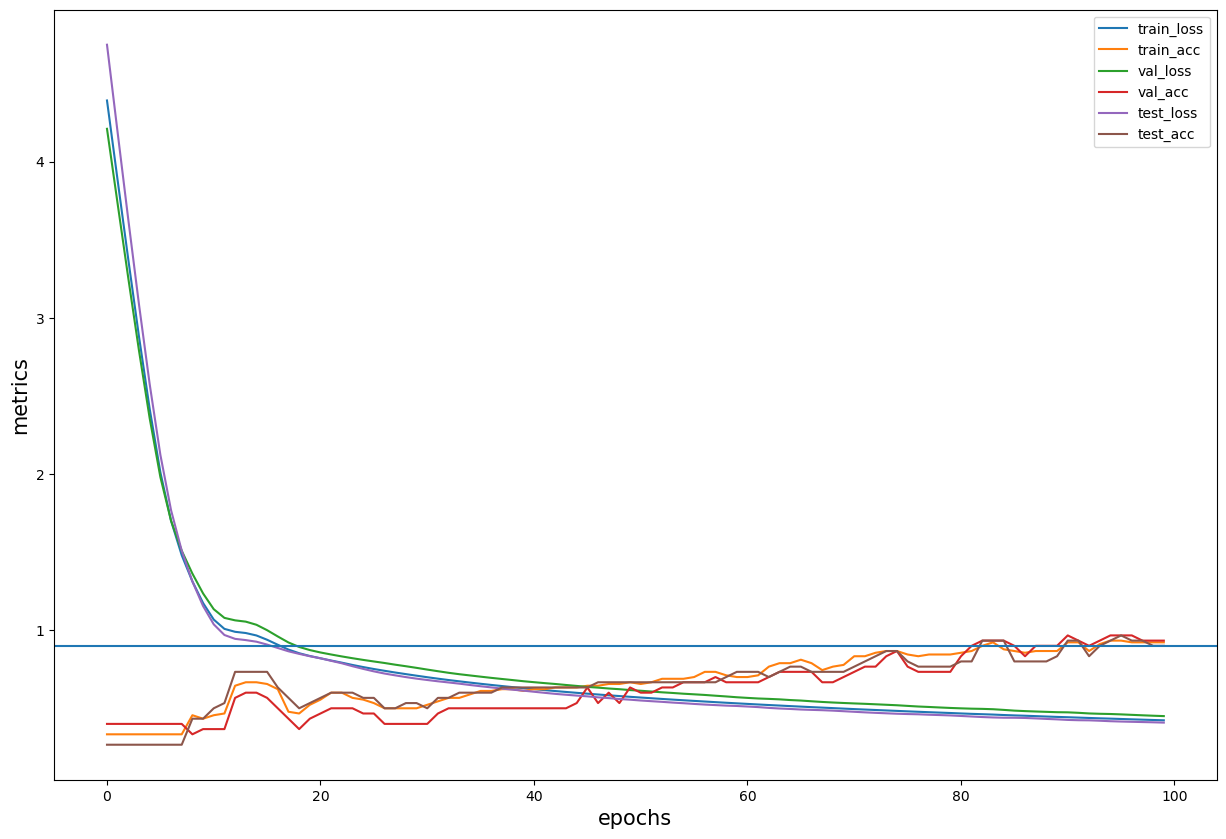

In [26]:
fig, ax  = plt.subplots(figsize = (15,10))
for col in df.columns:
    ax.plot(df.index, df[col], label = col)
ax.set_xlabel('epochs', fontsize = 15)
ax.set_ylabel('metrics', fontsize = 15)
ax.axhline(0.9)
ax.legend()